### analysis/analyze_sensitivity_parameter_sweep

- Processes neuron firing rates for simulations from a sweep of cell type sensitivity parameters (i.e. scalings of ORN/eLN/iLN/PN columns of the hemibrain connectivity matrix)
- Plots AL features for circuits with different sensitivity parameters, choosing best one for circuit idiosyncrasy analysis (ORNs x0.1, eLNs x0.04, iLNs x0.02, PNs x0.4)

In [1]:
import argparse
import os
import sys
file_path = 'C:/Users/dB/deBivort/projects/ALVariability/'
proj_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
sys.path.append(proj_dir)
import pandas as pd
import pickle
import re
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from PyPDF2 import PdfFileWriter, PdfFileReader
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
import seaborn as sns
import re
from datetime import datetime

from scipy.stats import kstest, ks_2samp

from utils.data_utils import make_df_AL_activity_long, make_orn_upn_frs, make_glomerular_odor_responses
from utils.plot_utils_EXTRA import plot_ornpn_hist, plot_fig_orn_pn_stats

from utils.plot_utils import set_font_sizes
set_font_sizes()

Load file storing firing rates of all simulations of the sweep, originally created by running `analysis/collect_col_sweep_frs.py`:

In [2]:
dfpick = pickle.load(open('sensitivity_sweep_20210427/all_simulations_frs.p', 'rb'))

In [3]:
project_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
df_neur_ids = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/df_neur_ids.csv'), index_col=0)
al_block = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/AL_block.csv'), index_col=0)
al_block.columns = al_block.columns.astype(np.int64)
al_block.index = al_block.index.astype(np.int64)
imput_table = pd.read_csv(os.path.join(project_dir, 'odor_imputation/df_odor_door_all_odors_imput_ALS.csv'), index_col=0)

Count number of ORNs in the 7 glomeruli measured in Bhandawat et al, 2007:

In [4]:
df_neur_ids_bhand_orns = df_neur_ids[(df_neur_ids.altype == 'ORN') & (df_neur_ids.glom.isin(['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2', 'VM2']))]
df_neur_ids_bhand_orns['glom'].value_counts()

VA2    97
DM1    86
DL1    84
DM2    79
DM3    68
DM4    60
VM2     1
Name: glom, dtype: int64

In [5]:
df_neur_ids[df_neur_ids.glom == 'VM2']

,bodyId,type,instance,altype,glom,polarity
2569,2074116622,ORN_VM2,ORN_VM2,ORN,VM2,1.0
2895,727472481,VM2_adPN,VM2_adPN_R,uPN,VM2,1.0
2896,697132371,VM2_adPN,VM2_adPN_R,uPN,VM2,1.0


VM2 has only 1 ORN, so we will exclude it when making comparisons to Bhandawat et al, 2007

In [6]:
df_neur_ids_bhand_upns = df_neur_ids[(df_neur_ids.altype == 'uPN') & (df_neur_ids.glom.isin(['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2', 'VM2']))]
df_neur_ids_bhand_upns

,bodyId,type,instance,altype,glom,polarity
2788,1977579449,VA2_adPN,VA2_adPN_R,uPN,VA2,1.0
2790,542634818,DM1_lPN,DM1_lPN_R,uPN,DM1,1.0
2794,1700937093,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0
2795,1700946301,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0
2808,630714299,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0
2809,5901222910,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0
2813,755518957,DM3_adPN,DM3_adPN_R,uPN,DM3,1.0
2814,1570685283,DM3_vPN,DM3_vPN_R,uPN,DM3,-1.0
2819,604031203,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0
2820,542652506,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0


In [7]:
neur_inputs = pd.Series(al_block.sum(0), name='num_synapse_inputs')
neur_inputs.index.name = 'bodyId_post'

In [8]:
df_neur_ids_bhand_upns.merge(neur_inputs, left_on='bodyId', right_on='bodyId_post', how='left')

,bodyId,type,instance,altype,glom,polarity,num_synapse_inputs
0,1977579449,VA2_adPN,VA2_adPN_R,uPN,VA2,1.0,4223.0
1,542634818,DM1_lPN,DM1_lPN_R,uPN,DM1,1.0,7280.0
2,1700937093,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0,3519.0
3,1700946301,DL1_adPN,DL1_adPN_R,uPN,DL1,1.0,3675.0
4,630714299,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0,2804.0
5,5901222910,DM2_lPN,DM2_lPN_R,uPN,DM2,1.0,2689.0
6,755518957,DM3_adPN,DM3_adPN_R,uPN,DM3,1.0,3452.0
7,1570685283,DM3_vPN,DM3_vPN_R,uPN,DM3,-1.0,131.0
8,604031203,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0,182.0
9,542652506,DM4_vPN,DM4_vPN_R,uPN,DM4,-1.0,75.0


In [9]:
thermo_hygro_glomeruli = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])

In [10]:
hemi_gloms = df_neur_ids[df_neur_ids.altype == 'ORN'].glom.value_counts().index.values

In [11]:
njobs = len(dfpick)

In [12]:
plotdir = './sensitivity_sweep_plots'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [13]:
odor_names = np.array(['benzaldehyde', 
                        'butyric acid',
                        '2,3-butanedione',
                        '1-butanol',
                        'cyclohexanone',
                        'Z3-hexenol', # originally 'cis-3-hexen-1-ol',
                        'ethyl butyrate',
                        'ethyl acetate',
                        'geranyl acetate',
                        'isopentyl acetate', # originally 'isoamyl acetate',
                        '4-methylphenol', # originally '4-methyl phenol',
                        'methyl salicylate',
                        '3-methylthio-1-propanol',
                        'octanal',
                        '2-octanone',
                        'pentyl acetate', 
                        'E2-hexenal', # originally 'trans-2-hexenal',
                        'gamma-valerolactone'])

In [14]:
plot_dir = os.path.join(plotdir, 'all_plots2')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [15]:
zscore = lambda x: ((x - np.mean(x.values)).T / np.std(x.values)).T

In [16]:
bhand_gloms = ['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2']#,, 'VM2']

In [17]:
df_neur_ids[df_neur_ids.altype == 'ORN'].glom.value_counts().loc[bhand_gloms]

DL1    84
DM1    86
DM2    79
DM3    68
DM4    60
VA2    97
Name: glom, dtype: int64

In [18]:
df_neur_ids[df_neur_ids.altype == 'uPN'].glom.value_counts().loc[bhand_gloms]

DL1    2
DM1    1
DM2    2
DM3    2
DM4    3
VA2    1
Name: glom, dtype: int64

In [19]:
def get_subtype_means(df_AL_activity):
    
    df_iln_activity = df_AL_activity.loc[df_AL_activity.neur_type == 'iLN'].set_index('neur_name')
    df_eln_activity = df_AL_activity.loc[df_AL_activity.neur_type == 'eLN'].set_index('neur_name')

    df_iln_on = df_iln_activity.loc[:, df_iln_activity.columns.str.contains('dur')]
    df_iln_off = df_iln_activity.loc[:, df_iln_activity.columns.str.contains('pre')]
    iln_off_mean = df_iln_off.mean().mean()
    iln_on_mean = df_iln_on.mean().mean()

    df_eln_on = df_eln_activity.loc[:, df_eln_activity.columns.str.contains('dur')]
    df_eln_off = df_eln_activity.loc[:, df_eln_activity.columns.str.contains('pre')]
    eln_off_mean = df_eln_off.mean().mean()
    eln_on_mean = df_eln_on.mean().mean()

    return iln_off_mean, iln_on_mean, eln_off_mean, eln_on_mean

In [20]:
df_neur_ids_bhand  = df_neur_ids.copy()[((df_neur_ids.altype == 'ORN') & (df_neur_ids.glom.isin(bhand_gloms))) | 
              (df_neur_ids.altype == 'LN') | 
               ((df_neur_ids.altype == 'uPN') & (df_neur_ids.glom.isin(bhand_gloms))) |
               (df_neur_ids.altype == 'mPN')
              ]

In [21]:
bhand_filepath = os.path.join(project_dir, 'datasets/Bhandawat2007/fig6_pn_orn_firing_rates/fig6_pn_orn_firing_rate_histograms.csv')
df_bhand = pd.read_csv(bhand_filepath)
df_bhand_pn = df_bhand[df_bhand.cell_type == 'PN']
df_bhand_orn = df_bhand[df_bhand.cell_type == 'ORN']

In [22]:
doplots = 0

In [23]:
res_d = {}
full_d = {}
doplots = False
for i in range(njobs):

    runvals= dfpick[i]['simvals']
    df_AL_activity = dfpick[i]['df_AL_activity']

    df_AL_activity_long = make_df_AL_activity_long(df_AL_activity)
    # remove non olfactory glomeruli
    df_AL_activity_long = df_AL_activity_long[~df_AL_activity_long.glom.isin(thermo_hygro_glomeruli)]


    st = 'a{}_e{}_i{}_p{}'.format(*runvals)


    df_orn_frs, df_upn_frs = make_orn_upn_frs(df_AL_activity, odor_names, df_neur_ids,
                                              sub_pre=True, olf_only=True)

    if doplots:
        plot_ornpn_hist(df_AL_activity_long, df_orn_frs, df_upn_frs)#, savetag=st+'_hist_onoff', 
                    #saveplot=True, savetodir=plot_dir, showplot=0)

    df_orn_glom_onoff, df_upn_glom_onoff = make_glomerular_odor_responses(df_orn_frs, df_upn_frs, df_AL_activity)
    fig_orn_pn = plt.figure(figsize=(12, 12))
    orn_onoff_dists, upn_onoff_dists = plot_fig_orn_pn_stats(fig_orn_pn,
                                                             df_orn_glom_onoff, 
                                                             df_upn_glom_onoff, 
                                                             'bwr', savetag=st+'_hmap_onoff', 
                                                             saveplot=0, savetodir=plot_dir, showplot=0, 
                                                             doplot=False); plt.close()


    '''
    ### Z Scored
    df_orn_glom_onoff_Z = zscore(df_orn_glom_onoff); df_upn_glom_onoff_Z = zscore(df_upn_glom_onoff)
    fig_orn_pn_Z = plt.figure(figsize=(12, 12))
    plot_fig_orn_pn_stats(fig_orn_pn_Z, df_orn_glom_onoff_Z, df_upn_glom_onoff_Z, 'bwr', savetag=st+'_hmap_onoff_Z', 
                    saveplot=1, savetodir=plot_dir, showplot=0); plt.close()
    '''

    ### BHANDAWAT VERSION
    df_AL_activity_bhand  = df_AL_activity.copy()[((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(bhand_gloms))) | 
              (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
               ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(bhand_gloms))) |
               (df_AL_activity.neur_type == 'mPN')
              ]
    df_AL_activity_long_bhand = make_df_AL_activity_long(df_AL_activity_bhand)
    df_orn_frs_bhand, df_upn_frs_bhand = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                                  sub_pre=True, olf_only=True)
    #plot_ornpn_hist(df_AL_activity_long_bhand, 
    #                df_orn_frs_bhand, df_upn_frs_bhand, savetag=st+'_hist_onoff_bhand', 
    #                saveplot=1, savetodir=plot_dir, showplot=0); plt.close()

    df_orn_glom_onoff_bhand, df_upn_glom_onoff_bhand = \
        make_glomerular_odor_responses(df_orn_frs_bhand, df_upn_frs_bhand, df_AL_activity_bhand)
    fig_orn_pn_bhand = plt.figure(figsize=(12, 12))
    orn_bhand_dists, upn_bhand_dists = plot_fig_orn_pn_stats(fig_orn_pn_bhand,
                                                             df_orn_glom_onoff_bhand, 
                                                             df_upn_glom_onoff_bhand, 
                                                             'bwr', savetag=st+'_hmap_onoff_bhand', 
                                                             saveplot=0, savetodir=plot_dir, showplot=0,
                                                             doplot=False); plt.close()
    


    df_orn_OFF_frs, df_upn_OFF_frs = make_orn_upn_frs(df_AL_activity, odor_names, df_neur_ids,
                                              sub_pre=False, olf_only=True, use_pre=True)

    upn_off_mean = df_upn_OFF_frs.mean().mean()

    iln_off_mean, iln_on_mean, eln_off_mean, eln_on_mean = get_subtype_means(df_AL_activity)

    full_d[st] = {'df_upn_glom_onoff': df_upn_glom_onoff,
                  'df_upn_glom_onoff_bhand': df_upn_glom_onoff_bhand,
                  'upn_bhand_dists': upn_bhand_dists,
                  'upn_onoff_dists': upn_onoff_dists,
                  'df_upn_OFF_frs': df_upn_OFF_frs
                 }



    res_d[st] = {'mean_upn_onoff_dists': np.mean(upn_onoff_dists),
                 'std_upn_onoff_dists': np.std(upn_onoff_dists),
                 'mean_upn_bhand_dists': np.mean(upn_bhand_dists),
                 'std_upn_bhand_dists': np.std(upn_bhand_dists), 

                 'mean_upn_onoff': np.mean(df_upn_glom_onoff.values),
                 'std_upn_onoff': np.std(df_upn_glom_onoff.values),
                 'mean_upn_bhand': np.mean(df_upn_glom_onoff_bhand.values),
                 'std_upn_bhand': np.std(df_upn_glom_onoff_bhand.values),
                 'max_upn_bhand': np.max(df_upn_glom_onoff_bhand.values),
                 
                 'upn_off_mean': upn_off_mean,
                 'iln_off_mean': iln_off_mean, 'iln_on_mean': iln_on_mean,
                 'eln_off_mean': eln_off_mean, 'eln_on_mean': eln_on_mean,
                 
                 

                 'a': runvals[0], 'e': runvals[1], 'i': runvals[2], 'p': runvals[3]
                 #'frac_upn_dists_larger': sum(upn_onoff_dists > orn_onoff_dists) / len(upn_onoff_dists),
                 #'frac_upn_dists_larger_bhand': sum(upn_bhand_dists > orn_bhand_dists) / len(upn_bhand_dists)
                }

    if i % 20 == 0:
        print(i)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520


In [24]:
from sklearn.decomposition import PCA

def make_PCA_projections(df_orn_glom_onoff_bhand, df_upn_glom_onoff_bhand):
    
    # get odor x glomerulus tables for ORNs, uPNs
    df_sim_orn = df_orn_glom_onoff_bhand.T
    df_sim_upn = df_upn_glom_onoff_bhand.T
    # center them
    df_sim_orn_c = df_sim_orn - df_sim_orn.mean(0)
    df_sim_upn_c = df_sim_upn - df_sim_upn.mean(0)
    # perform PCA
    ornPCA = PCA()
    ornPCA.fit(df_sim_orn_c)
    orn_projections = ornPCA.fit_transform(df_sim_orn_c)[:, :2]
    upnPCA = PCA()
    upnPCA.fit(df_sim_upn_c)
    upn_projections = upnPCA.fit_transform(df_sim_upn_c)[:, :2]
    
    dfORNpca = orn_projections[:, :2]
    dfPNpca = upn_projections[:, :2]
    
    return dfORNpca, dfPNpca

def plot_PC_projections(dfORNpca, dfPNpca, odor_names, savetag='',
                    saveplot=False, savetodir='./', showplot=False):
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))
    axs[0].set_title('ORNs')
    for i in range(len(dfORNpca)):
        axs[0].scatter(dfORNpca[i, 1], dfORNpca[i, 0], label=odor_names[i])
    axs[0].set_xlabel('projection onto PC 2')
    axs[0].set_ylabel('projection onto PC 1')
    
    axs[1].set_title('PNs')
    for i in range(len(dfPNpca)):
        axs[1].scatter(dfPNpca[i, 1], dfPNpca[i, 0], label=odor_names[i])
    
    for ax in axs:
        #ax.axis('equal')
        ax.axvline(0, ls='--', color='0.5')
        ax.axhline(0, ls='--', color='0.5')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, ncol=2)
    if saveplot:
        plt.savefig(os.path.join(savetodir, f'{savetag}.png'), bbox_inches='tight')
    if showplot:
        plt.show()
        
    plt.close()
    
    
def plot_PC_distances(bhand_pca_orndists, bhand_pca_pndists, savetag='',
                    saveplot=False, savetodir='./', showplot=False):
    
    mindist = min(min(bhand_pca_orndists), min(bhand_pca_pndists)); maxdist = max(max(bhand_pca_orndists), max(bhand_pca_pndists))
    b = np.linspace(mindist, maxdist, 2*12)  


    plt.figure(figsize=(13,4))
    ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((1, 3), (0, 2))
    
    ax1.hist(bhand_pca_orndists, alpha=0.5, bins=b, label='ORN', color='xkcd:light blue')
    ax1.hist(bhand_pca_pndists, alpha=0.5, bins=b, label='PN', color='xkcd:navy')
    ax1.set_xlabel('pairwise euclidean distance between\nPCA projected odors')
    ax1.set_ylabel('# odor pairs')
    ax1.legend()
    
    ax2.scatter(bhand_pca_orndists, bhand_pca_pndists, color='k')
    ax2.plot([mindist, maxdist], [mindist, maxdist], color='0.5', ls='--')
    ax2.axis('equal')
    ax2.set_xlabel('pairwise dist between ORN PCA-projected odors')
    ax2.set_ylabel('pairwise dist between PN PCA-projected odors')
    
    plt.subplots_adjust(wspace=0.4)
    
    if saveplot:
        plt.savefig(os.path.join(savetodir, f'{savetag}.png'), bbox_inches='tight')
    if showplot:
        plt.show()
        
    plt.close()

In [25]:
bhand_df = pd.read_csv('../datasets/Bhandawat2007/fig3_responses/fig3_firing_rates.csv')
df_bhand_pn_glom_by_odor = bhand_df[bhand_df.cell_type == 'PN'].pivot('glomerulus', 'odor', 'firing_rate')
model_arr = df_bhand_pn_glom_by_odor.values.flatten()
dur_cols = [c for c in df_AL_activity.columns if '_dur_' in c]

In [26]:
res_d_PCA = {}
full_d_PCA = {}
doplots = False
for i in range(njobs):

    runvals= dfpick[i]['simvals']
    
    st = 'a{}_e{}_i{}_p{}'.format(*runvals)
    
    
    df_AL_activity = dfpick[i]['df_AL_activity']

    ### BHANDAWAT VERSION
    df_AL_activity_bhand  = df_AL_activity.copy()[((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(bhand_gloms))) | 
              (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
               ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(bhand_gloms))) |
               (df_AL_activity.neur_type == 'mPN')
              ]
    df_orn_frs_onoff_bhand, df_upn_frs_onoff_bhand = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                                  sub_pre=True, olf_only=True)
    
    df_orn_glom_by_odor_onoff_bhand, df_upn_glom_by_odor_onoff_bhand = \
        make_glomerular_odor_responses(df_orn_frs_onoff_bhand, df_upn_frs_onoff_bhand, df_AL_activity_bhand)
    
    dfORNpca, dfPNpca = make_PCA_projections(df_orn_glom_by_odor_onoff_bhand, df_upn_glom_by_odor_onoff_bhand)

    bhand_pca_orndists = pdist(dfORNpca, metric='euclidean')
    bhand_pca_pndists = pdist(dfPNpca, metric='euclidean')
    
    dm1_PN_pre_odor = df_AL_activity_bhand[df_AL_activity_bhand.neur_name == 'uPN_DM1_0']['fr_pre_odor0'].values[0]
    va2_PN_pre_odor = df_AL_activity_bhand[df_AL_activity_bhand.neur_name == 'uPN_VA2_0']['fr_pre_odor0'].values[0]
    vm2_PN_dur_all_odors = np.mean(df_AL_activity.loc[df_AL_activity.neur_name == 'uPN_VM2_0', dur_cols].values)
    
    bhand_arr = df_upn_glom_by_odor_onoff_bhand.values.flatten()
    kstest_stat, kstest_pval = kstest(model_arr, bhand_arr)
    kstest_2samp_stat, _ = ks_2samp(model_arr, bhand_arr)

    #plot_PC_projections(dfORNpca, dfPNpca, odor_names, 
    #                     savetag=st+'_PCA_projections', saveplot=1, savetodir=plot_dir, showplot=0)
    #plot_PC_distances(bhand_pca_orndists, bhand_pca_pndists,
    #                     savetag=st+'_PCA_distances', saveplot=1, savetodir=plot_dir, showplot=0)
    res_d_PCA[st] = {'mean_pca_orn_dists': np.mean(bhand_pca_orndists), 
                     'std_pca_orn_dists': np.std(bhand_pca_orndists),
                     'mean_pca_upn_dists': np.mean(bhand_pca_pndists),
                     'std_pca_upn_dists': np.std(bhand_pca_pndists),
                     'max_pca_upn_dists': np.max(bhand_pca_pndists),
                     'DM1_PN_pre_odor_fr': dm1_PN_pre_odor,
                     'VA2_PN_pre_odor_fr': va2_PN_pre_odor,
                     'VM2_PN_dur_odor_fr': vm2_PN_dur_all_odors,
                     'min_PN_dur': np.min(bhand_arr),
                     'kstest_stat': kstest_stat, 'kstest_pval': kstest_pval,
                     'kstest_2samp_stat': kstest_2samp_stat,
                     'a': runvals[0], 'e': runvals[1], 'i': runvals[2], 'p': runvals[3]
                }
    ## near 500
    ## if st == 'a0.1_e0.25_i0.2_p6.0':
    ##   break
    ## near 320
    ##if st == 'a0.1_e0.4_i0.2_p4.0':
    ##   break
        
    if i % 20 == 0:
        print(i)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520


In [27]:
new_d = {}
for i in range(njobs):

    runvals= dfpick[i]['simvals']   
    st = 'a{}_e{}_i{}_p{}'.format(*runvals)
    
    cur_d = full_d[st]
    
    frs_upn_glom_onoff = cur_d['df_upn_glom_onoff'].values.flatten()
    frs_upn_glom_onoff_bhand = cur_d['df_upn_glom_onoff_bhand'].values.flatten()
    
    frac_less_full = sum(frs_upn_glom_onoff < 100) / len(frs_upn_glom_onoff)
    frac_less_bhand = sum(frs_upn_glom_onoff_bhand < 100) / len(frs_upn_glom_onoff_bhand)
    
    # squared distance from Bhandawat hist
    # align to bhandawat data
    b = np.arange(-200, 500, 20)
    cnts, left_pts = np.histogram(cur_d['df_upn_glom_onoff_bhand'].values.flatten(), bins=b)
    sim_pn_fracs = pd.Series(cnts/sum(cnts), index=left_pts[:-1], name='sim_PN')
    sim_pn_fracs.index = sim_pn_fracs.index.rename('fr')
    df_compare_pns_peak = pd.DataFrame(sim_pn_fracs).merge(df_bhand_pn, left_on='fr', 
                                                       right_on='firing_rate').fillna(0)
    pn_sq_dist_bhandgloms = np.sum((df_compare_pns_peak['fraction'] - df_compare_pns_peak['sim_PN'])**2)
    
    cnts, left_pts = np.histogram(cur_d['df_upn_glom_onoff'].values.flatten(), bins=b)
    sim_pn_fracs = pd.Series(cnts/sum(cnts), index=left_pts[:-1], name='sim_PN')
    sim_pn_fracs.index = sim_pn_fracs.index.rename('fr')
    df_compare_pns_peak = pd.DataFrame(sim_pn_fracs).merge(df_bhand_pn, left_on='fr', 
                                                       right_on='firing_rate').fillna(0)
    pn_sq_dist_allgloms = np.sum((df_compare_pns_peak['fraction'] - df_compare_pns_peak['sim_PN'])**2)
    
    
    
    new_d[st] = {'frac_less_full': frac_less_full,
                 'frac_less_bhand': frac_less_bhand,
                 'pn_sq_dist_bhandgloms': pn_sq_dist_bhandgloms,
                 'pn_sq_dist_allgloms': pn_sq_dist_allgloms,
                 }

In [28]:
df_res = pd.DataFrame.from_dict(res_d).T
df_new = pd.DataFrame.from_dict(new_d).T
df_res = pd.concat((df_res, df_new), 1)

df_res_PCA = pd.DataFrame.from_dict(res_d_PCA).T

df_res = pd.concat((df_res, df_res_PCA), 1)
df_res = df_res.loc[:,~df_res.columns.duplicated()]

In [29]:
df_res_cols = df_res.columns
df_res_cols
df_res_cols1 = [c for c in df_res_cols if c not in ['a', 'e', 'i', 'p']]

In [30]:
def plot_sweep_res(x_var, y_var, c_var, x_lab='', y_lab='', c_lab='', 
                   highlight_locs=['a0.1_e0.25_i0.65_p8.0']):
    
    x_lab = x_var if x_lab == '' else x_lab
    y_lab = y_var if y_lab == '' else y_lab
    c_lab = c_var if c_lab == '' else c_lab
    
    plot_df = df_res
    plt.figure(figsize=(12,7))
    # all sims
    sc = plt.scatter(plot_df[x_var], plot_df[y_var], c=plot_df[c_var])
    # highlight base paramter config
    
    for loc in highlight_locs:
        plot_df = df_res.loc[loc]
        plt.scatter(plot_df[x_var], plot_df[y_var], label=loc, edgecolor='w', linewidth=2, marker='*', s=500)
    
    #plot_df = df_res.loc['a0.1_e0.25_i0.45_p6.0']
    #plt.scatter(plot_df[x_var], plot_df[y_var], c='r', marker='*', s=300)
    if len(highlight_locs) > 0:
        plt.legend(title='highlighted runs', bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0)
    plt.xlabel(x_lab); plt.ylabel(y_lab)
    plt.colorbar(sc, label=c_lab)
    plt.show()
    
    return x_var, y_var, c_var

In [31]:
df_simvals = df_res[['a', 'e', 'i', 'p']].sort_values(['a', 'e', 'i', 'p']).reset_index(drop=True)
df_simvals['success'] = 1

a_vals = df_simvals['a'].value_counts().index.values
e_vals = df_simvals['e'].value_counts().index.values
i_vals = df_simvals['i'].value_counts().index.values
p_vals = df_simvals['p'].value_counts().index.values

rows_to_add = []
for a_val in a_vals:
    sub_1df = df_simvals[df_simvals['a'] == a_val]

    for e_val in e_vals:
        sub_2df = sub_1df[sub_1df['e'] == e_val]
        for i_val in i_vals:
            sub_3df = sub_2df[sub_2df['i'] == i_val]
            for p_val in p_vals:
                sub_4df = sub_3df[sub_3df['p'] == p_val]
                if sub_4df.shape[0] == 0:
                    new_row = [a_val, e_val, i_val, p_val, 0]
                    rows_to_add.append(new_row)
                    
df_simvals_unsuccessful = pd.DataFrame(rows_to_add, columns=['a', 'e', 'i', 'p', 'success'])
df_simvals = pd.concat((df_simvals, df_simvals_unsuccessful)).sort_values(['a', 'e', 'i', 'p']).reset_index(drop=True)
df_simvals

,a,e,i,p,success
0,0.1,0.1,0.2,2.0,1
1,0.1,0.1,0.2,4.0,1
2,0.1,0.1,0.2,6.0,1
3,0.1,0.1,0.2,8.0,1
4,0.1,0.1,0.2,10.0,1
...,...,...,...,...,...
580,0.1,0.5,1.0,2.0,1
581,0.1,0.5,1.0,4.0,1
582,0.1,0.5,1.0,6.0,1
583,0.1,0.5,1.0,8.0,1


### Scatter plots of model characteristics for different sensitivity parameter sets

Each point is a model with an (ORN, eLN, iLN, PN) sensitivity parameter. Axes are different model characteristics such as uPN off-odor firing rate (should be close to 0), and a distance to the Bhandawat et al, 2007 PN firing rate histogram (which is rather flat for PNs -- more uniform than the ORN distribution)

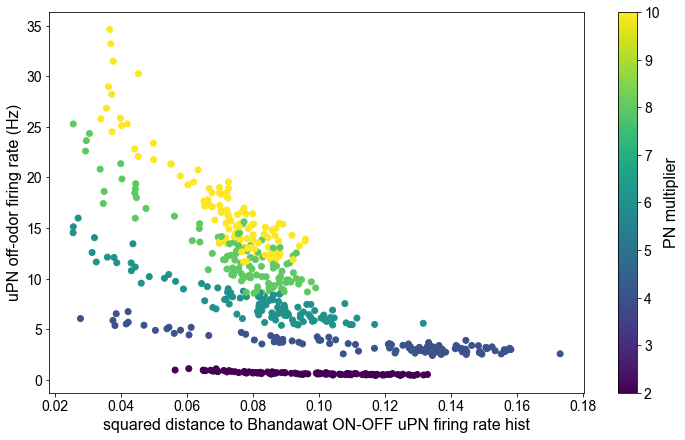

In [32]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms', x_lab = 'squared distance to Bhandawat ON-OFF uPN firing rate hist',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[],#'a0.1_e0.4_i0.2_p4.0']
)



In [33]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.03) &
       (df_res[y_var] < 15) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_pca_upn_dists')[['pn_sq_dist_bhandgloms', 'upn_off_mean']]

,pn_sq_dist_bhandgloms,upn_off_mean
a0.1_e0.4_i0.2_p4.0,0.027608,6.052991
a0.1_e0.4_i0.2_p6.0,0.025386,14.531624


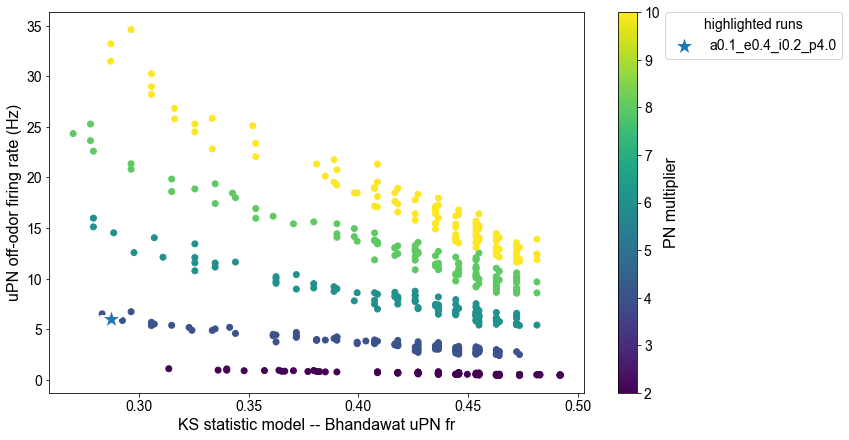

In [34]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'kstest_stat', x_lab = 'KS statistic model -- Bhandawat uPN fr',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0']
)



In [35]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.32) &
       (df_res[y_var] < 10) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_pca_upn_dists')[['pn_sq_dist_bhandgloms', 'upn_off_mean']]

,pn_sq_dist_bhandgloms,upn_off_mean
a0.1_e0.5_i0.2_p2.0,0.060490,1.102564
a0.1_e0.3_i0.2_p4.0,0.042108,5.692308
a0.1_e0.25_i0.2_p4.0,0.041499,5.517949
a0.1_e0.5_i0.2_p4.0,0.042068,6.736752
a0.1_e0.15_i0.2_p4.0,0.046887,5.394872
a0.1_e0.4_i0.2_p4.0,0.027608,6.052991
a0.1_e0.2_i0.2_p4.0,0.038086,5.365812
a0.1_e0.35_i0.2_p4.0,0.037471,5.866667
a0.1_e0.45_i0.2_p4.0,0.038452,6.529915


Highlight a simulation with low distance from the target flat distribution of PN firing rates, and a not-too-negative minimum PN on-off firing rate (which barely are below 0 in Bhandawat et al, 2007 Figure 6b)

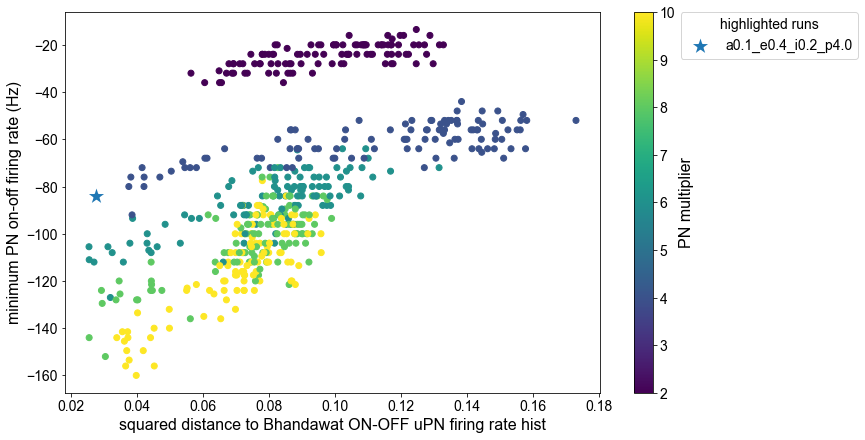

In [36]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms', x_lab = 'squared distance to Bhandawat ON-OFF uPN firing rate hist',
    y_var = 'min_PN_dur', y_lab = 'minimum PN on-off firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0']
)



--> Identifying the model with ORNs x0.1, eLNs x0.04, iLNs x0.02, PNs x0.4 as the best-performing model, with small deviation to the Bhandawat 2007 et al ON-OFF PN firing rate distribution, and not-too-negative minimum PN on-off firing rate.

In [37]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 0.041) &
       (df_res[y_var] > -100) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('pn_sq_dist_bhandgloms')[['pn_sq_dist_bhandgloms', 'a']]

,pn_sq_dist_bhandgloms,a
a0.1_e0.4_i0.2_p4.0,0.027608,0.1
a0.1_e0.35_i0.2_p4.0,0.037471,0.1
a0.1_e0.2_i0.2_p4.0,0.038086,0.1
a0.1_e0.45_i0.2_p4.0,0.038452,0.1
a0.1_e0.45_i0.3_p6.0,0.038618,0.1


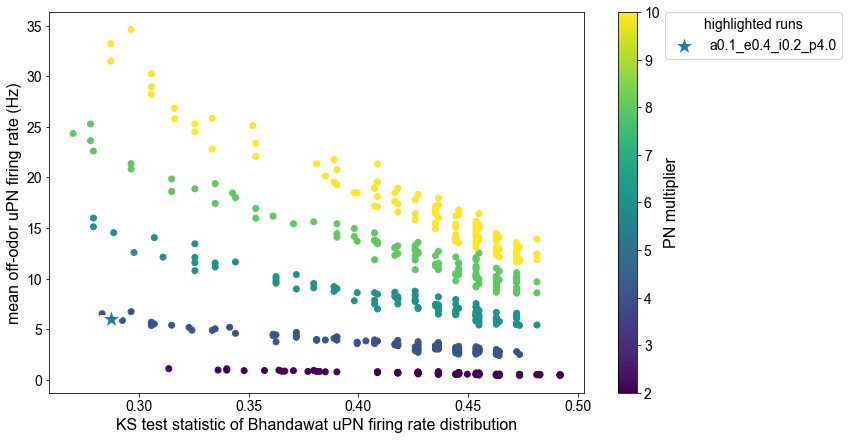

In [38]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'kstest_stat', x_lab = 'KS test statistic of Bhandawat uPN firing rate distribution',
    y_var = 'upn_off_mean', y_lab = 'mean off-odor uPN firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0'],#'a0.1_e0.25_i0.2_p6.0']
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [39]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 0.33) &
       (df_res[y_var] < 7) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.45_i0.2_p4.0,561.069537,118.254581,280.417160,93.802481,45.591644,66.109681,63.685957,89.131529,286.50,6.529915,...,220.157914,107.310734,508.552228,68.0,28.0,0.0,-92.0,0.283069,0.000133,0.283069
a0.1_e0.4_i0.2_p4.0,566.496508,118.855839,285.256129,95.201347,45.694408,66.429010,64.111883,90.134273,293.00,6.052991,...,221.199050,110.536663,494.742969,76.0,32.0,0.0,-84.0,0.287037,0.000101,0.287037
a0.1_e0.35_i0.2_p4.0,568.394040,117.936114,285.012905,97.093254,45.112219,66.444472,63.020062,90.200823,305.00,5.866667,...,220.694763,109.751562,501.564582,76.0,40.0,0.0,-80.0,0.292328,0.000070,0.292328
a0.1_e0.5_i0.2_p4.0,565.046197,118.863910,280.537383,93.504112,46.216880,66.479202,63.301698,88.809643,283.25,6.736752,...,220.248523,106.808077,491.910384,76.0,28.0,0.0,-80.0,0.296296,0.000053,0.296296
a0.1_e0.3_i0.2_p4.0,566.225195,117.633535,286.758283,97.868763,44.782580,66.324000,63.459105,90.891225,289.00,5.692308,...,224.940710,111.359087,483.852508,80.0,24.0,0.0,-76.0,0.305556,0.000027,0.305556
a0.1_e0.2_i0.2_p4.0,568.066928,119.482380,286.426757,97.480844,43.629021,66.228442,61.815586,90.639696,299.00,5.365812,...,223.546464,111.501029,495.291830,64.0,36.0,0.0,-76.0,0.305556,0.000027,0.305556
a0.1_e0.25_i0.2_p4.0,564.584218,118.725497,285.200934,96.499578,44.240418,66.089001,63.312500,90.158445,293.00,5.517949,...,221.808726,111.246110,483.867013,68.0,36.0,0.0,-72.0,0.306878,0.000024,0.306878
a0.1_e0.5_i0.2_p2.0,393.964029,85.008461,212.950745,82.155096,26.962450,46.109054,51.702160,68.006745,266.50,1.102564,...,167.150844,93.254952,382.415942,32.0,0.0,0.0,-36.0,0.313492,0.000015,0.313492
a0.1_e0.15_i0.2_p4.0,568.005206,118.069873,286.879907,97.889750,42.596982,65.893291,62.131173,90.703323,301.00,5.394872,...,223.979962,111.217059,494.620908,64.0,28.0,0.0,-76.0,0.314815,0.000013,0.314815
a0.1_e0.5_i0.3_p4.0,568.655252,118.771030,287.669949,98.321139,43.231309,66.185090,62.490741,90.913906,292.50,5.181197,...,226.227176,112.067239,479.039795,60.0,28.0,0.0,-68.0,0.322751,0.000007,0.322751


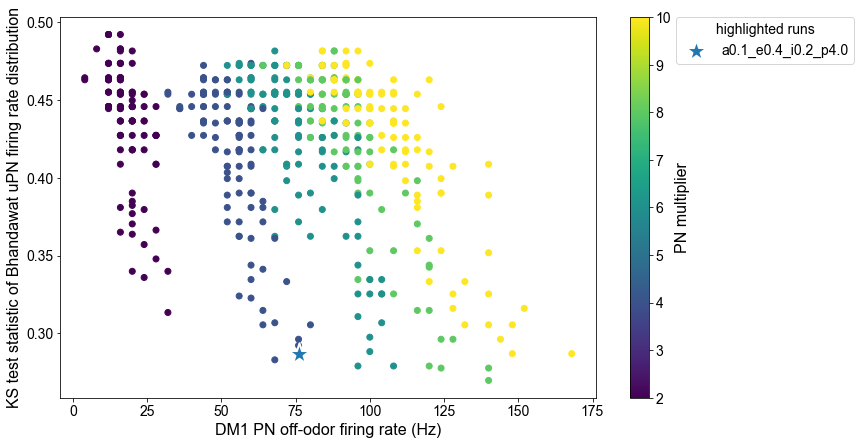

In [40]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'DM1_PN_pre_odor_fr', x_lab = 'DM1 PN off-odor firing rate (Hz)',
    y_var = 'kstest_stat', y_lab = 'KS test statistic of Bhandawat uPN firing rate distribution',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=['a0.1_e0.4_i0.2_p4.0'],#, 'a0.1_e0.5_i0.2_p2.0']
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [41]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 40) &
       (df_res[y_var] < 0.33) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.5_i0.2_p2.0,393.964029,85.008461,212.950745,82.155096,26.96245,46.109054,51.70216,68.006745,266.5,1.102564,...,167.150844,93.254952,382.415942,32.0,0.0,0.0,-36.0,0.313492,0.000015,0.313492


In [42]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 75) &
       (df_res[y_var] < 0.3) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.45_i0.2_p4.0,561.069537,118.254581,280.41716,93.802481,45.591644,66.109681,63.685957,89.131529,286.5,6.529915,...,220.157914,107.310734,508.552228,68.0,28.0,0.0,-92.0,0.283069,0.000133,0.283069


In [43]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 15) &
       (df_res[y_var] < 0.3) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat


In [44]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] > 0.48) &
       #(df_res[y_var] < 0.03) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('kstest_stat')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.45_i0.2_p8.0,739.471028,152.422404,333.964259,103.543433,64.336352,86.383494,73.449846,104.714037,311.0,24.331624,...,254.932099,121.346518,592.751862,140.0,60.0,0.0,-152.0,0.269841,3.206488e-04,0.269841
a0.1_e0.4_i0.2_p8.0,742.144172,151.728246,339.228490,104.633333,63.683987,86.184698,72.613426,105.660476,316.5,23.632479,...,258.800665,121.780845,579.603074,140.0,56.0,0.0,-129.5,0.277778,1.901510e-04,0.277778
a0.1_e0.5_i0.2_p8.0,736.048932,150.936073,335.199110,103.905429,64.597762,85.958821,73.331019,105.057396,323.0,25.276923,...,253.760641,121.779614,598.904351,124.0,68.0,0.0,-144.0,0.277778,1.901510e-04,0.277778
a0.1_e0.5_i0.2_p6.0,669.920395,142.445563,314.859562,100.726367,56.604870,78.183603,68.662809,98.686532,307.0,15.977778,...,240.291467,116.983640,570.209957,108.0,56.0,0.0,-112.0,0.279101,1.740242e-04,0.279101
a0.1_e0.45_i0.2_p6.0,670.826541,138.636239,319.896211,102.450207,56.875536,78.564340,69.246142,100.769529,305.5,15.116239,...,248.081857,116.998290,561.472581,96.0,52.0,0.0,-111.0,0.279101,1.740242e-04,0.279101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0.1_e0.25_i0.9_p2.0,375.817339,80.217795,211.199818,88.736338,20.595579,42.569444,43.259259,67.505767,277.5,0.512821,...,166.395736,99.333250,385.785486,16.0,0.0,0.0,-20.0,0.492063,2.595701e-13,0.492063
a0.1_e0.45_i1.0_p2.0,376.173764,81.390950,211.024690,90.759972,20.652732,42.724264,43.472222,67.693708,285.5,0.463248,...,167.037764,100.607618,400.023087,12.0,0.0,0.0,-24.0,0.492063,2.595701e-13,0.492063
a0.1_e0.15_i1.0_p2.0,373.426258,78.645838,209.662789,89.580343,20.163140,42.332461,43.496142,67.420951,284.0,0.483761,...,165.102834,99.140760,392.218200,12.0,0.0,0.0,-16.0,0.492063,2.595701e-13,0.492063
a0.1_e0.1_i1.0_p2.0,372.062760,79.856625,209.271586,88.737513,20.197826,42.169680,42.735340,67.041094,279.0,0.441026,...,165.583602,98.367458,395.190722,12.0,0.0,0.0,-28.0,0.492063,2.595701e-13,0.492063


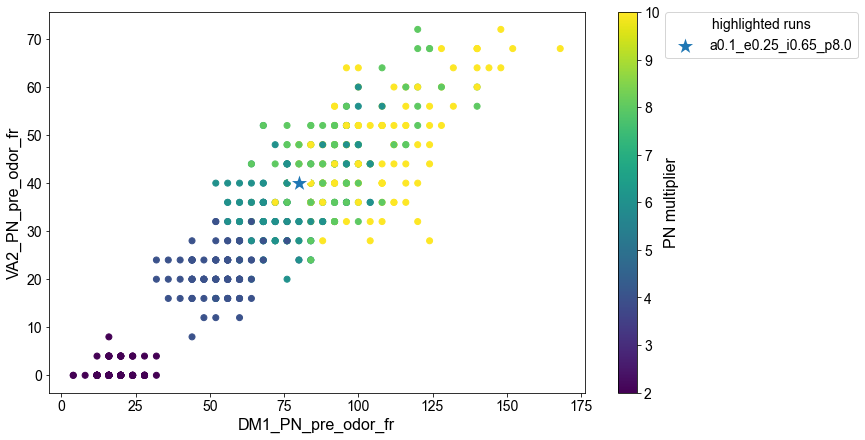

In [45]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'DM1_PN_pre_odor_fr',
    y_var = 'VA2_PN_pre_odor_fr',
    c_var = 'p', c_lab='PN multiplier',
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



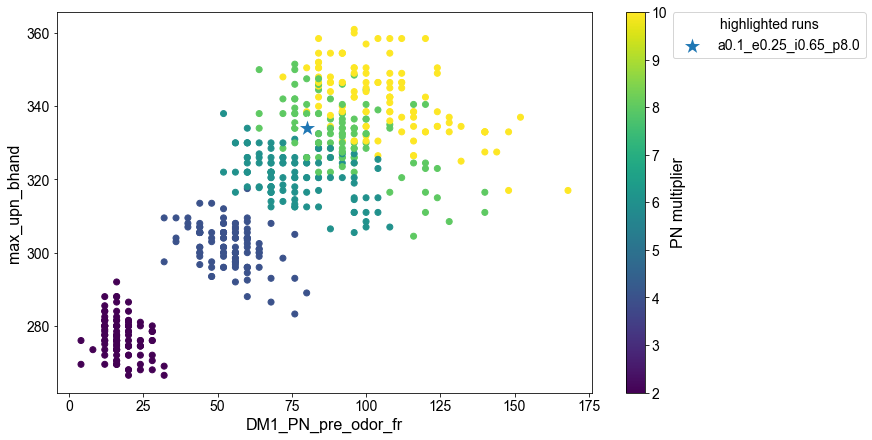

In [46]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'DM1_PN_pre_odor_fr',
    y_var = 'max_upn_bhand',
    c_var = 'p', c_lab='PN multiplier',
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [47]:
sub_df = df_res[
       #(df_res['p'] == 6) & 
       (df_res[x_var] < 30) &
       #(df_res[y_var] < 0.03) &
       #(df_res['upn_off_mean'] < 15) &
       #(df_res['eln_on_mean'] < 40) &
       # (df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('frac_less_bhand')['frac_less_bhand']#.iloc[:5]

a0.1_e0.35_i0.2_p2.0    0.787037
a0.1_e0.2_i0.2_p2.0     0.796296
a0.1_e0.15_i0.2_p2.0    0.796296
a0.1_e0.3_i0.2_p2.0     0.796296
a0.1_e0.5_i0.3_p2.0     0.796296
                          ...   
a0.1_e0.45_i0.8_p2.0    0.824074
a0.1_e0.25_i0.9_p2.0    0.824074
a0.1_e0.15_i0.9_p2.0    0.824074
a0.1_e0.15_i0.6_p2.0    0.824074
a0.1_e0.4_i1.0_p2.0     0.824074
Name: frac_less_bhand, Length: 103, dtype: float64

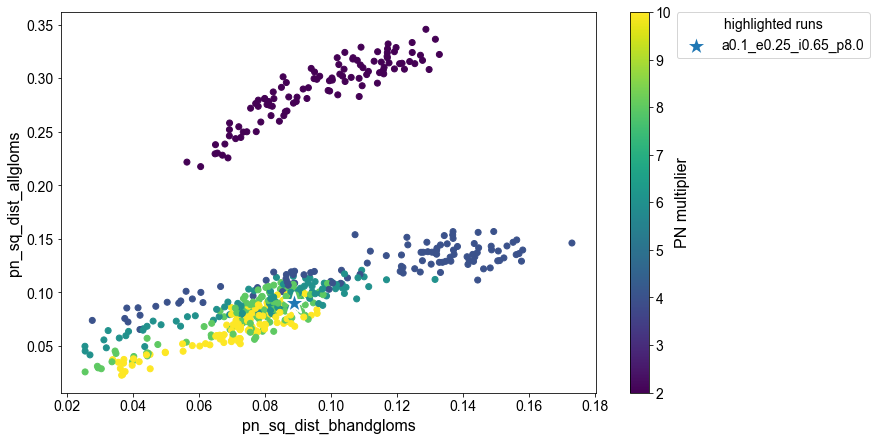

In [48]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms',
    y_var = 'pn_sq_dist_allgloms',
    c_var = 'p', c_lab='PN multiplier',
    #highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
    #                'a0.1_e0.25_i0.45_p6.0',
    #                'a0.1_e0.3_i0.45_p4.0']
)



In [49]:
highlight_locs=['a0.1_e0.25_i0.65_p8.0', 
                 'a0.1_e0.4_i0.75_p6.0']

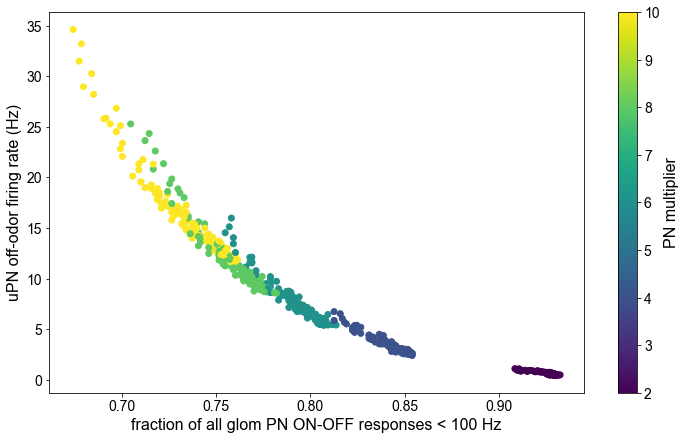

In [50]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'frac_less_full', x_lab = 'fraction of all glom PN ON-OFF responses < 100 Hz',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [51]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.8) &
       (df_res[y_var] < 15) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1]#.sort_values('max_pca_upn_dists')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.4_i0.8_p6.0,669.663060,133.063065,336.702923,111.244240,45.693714,77.019312,64.610340,105.536488,322.0,6.100855,...,261.242810,129.986657,571.939591,60.0,28.0,0.0,-76.0,0.462963,8.836154e-12,0.462963
a0.1_e0.15_i0.7_p6.0,673.074102,134.102058,340.632894,117.780425,45.058597,77.229613,62.635802,106.949771,328.5,6.347009,...,265.695284,137.122335,577.458747,68.0,28.0,0.0,-96.0,0.455026,2.213274e-11,0.455026
a0.1_e0.25_i0.75_p6.0,673.414874,132.977848,335.040700,114.012940,44.976362,77.271654,62.732253,105.186655,326.0,6.360684,...,262.376150,131.782106,567.189313,72.0,28.0,0.0,-81.5,0.455026,2.213274e-11,0.455026
a0.1_e0.3_i0.75_p6.0,675.467163,132.874608,339.963631,113.535471,45.464343,77.339848,62.219136,105.916280,324.5,6.377778,...,262.375786,133.126644,574.462084,72.0,32.0,0.0,-84.0,0.453704,2.574641e-11,0.453704
a0.1_e0.45_i0.8_p6.0,671.220781,131.961677,330.878985,110.468858,45.282457,77.040621,63.478395,103.520776,324.5,6.441026,...,253.743262,128.090018,553.764072,60.0,24.0,0.0,-80.0,0.453704,2.574641e-11,0.453704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0.1_e0.45_i0.7_p10.0,827.818984,160.465263,390.148247,121.158004,59.082131,94.685433,72.739198,120.215683,360.0,14.789744,...,299.102871,142.858804,667.148459,96.0,32.0,0.0,-112.0,0.453704,2.574641e-11,0.453704
a0.1_e0.5_i0.7_p10.0,824.919928,159.561153,387.096334,117.594138,59.455043,94.361615,73.059414,119.207710,346.5,14.905983,...,295.077607,139.712378,636.488931,92.0,52.0,0.0,-100.0,0.435185,2.028138e-10,0.435185
a0.1_e0.25_i0.65_p10.0,827.530285,160.278282,391.746941,120.485818,58.056454,94.447558,70.942901,120.618099,330.5,14.950427,...,303.301632,142.802057,614.509232,96.0,40.0,0.0,-108.0,0.455026,2.213274e-11,0.455026
a0.1_e0.4_i0.4_p8.0,763.632978,151.546996,361.652596,112.120552,58.941304,87.906210,70.997685,111.578477,340.5,14.953846,...,277.251910,131.221811,617.313108,116.0,48.0,0.0,-112.0,0.398148,9.395075e-09,0.398148


In [52]:
df_res_cols1

['mean_upn_onoff_dists',
 'std_upn_onoff_dists',
 'mean_upn_bhand_dists',
 'std_upn_bhand_dists',
 'mean_upn_onoff',
 'std_upn_onoff',
 'mean_upn_bhand',
 'std_upn_bhand',
 'max_upn_bhand',
 'upn_off_mean',
 'iln_off_mean',
 'iln_on_mean',
 'eln_off_mean',
 'eln_on_mean',
 'frac_less_full',
 'frac_less_bhand',
 'pn_sq_dist_bhandgloms',
 'pn_sq_dist_allgloms',
 'mean_pca_orn_dists',
 'std_pca_orn_dists',
 'mean_pca_upn_dists',
 'std_pca_upn_dists',
 'max_pca_upn_dists',
 'DM1_PN_pre_odor_fr',
 'VA2_PN_pre_odor_fr',
 'VM2_PN_dur_odor_fr',
 'min_PN_dur',
 'kstest_stat',
 'kstest_pval',
 'kstest_2samp_stat']

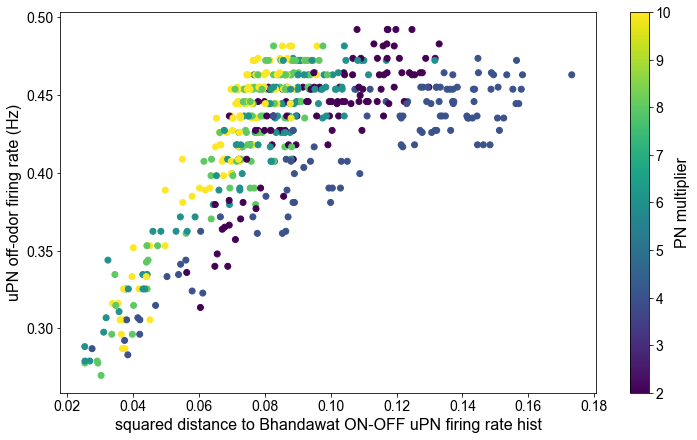

In [53]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'pn_sq_dist_bhandgloms', x_lab = 'squared distance to Bhandawat ON-OFF uPN firing rate hist',
    y_var = 'kstest_stat', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [54]:
df_simvals.iloc[391-20:391+20]

,a,e,i,p,success
371,0.1,0.35,0.75,4.0,1
372,0.1,0.35,0.75,6.0,1
373,0.1,0.35,0.75,8.0,1
374,0.1,0.35,0.75,10.0,1
375,0.1,0.35,0.80,2.0,1
376,0.1,0.35,0.80,4.0,1
377,0.1,0.35,0.80,6.0,1
378,0.1,0.35,0.80,8.0,1
379,0.1,0.35,0.80,10.0,1
380,0.1,0.35,0.90,2.0,1


In [55]:
sub_df = df_res[
       #(df_res['p'] == 4) & 
       (df_res[x_var] < 0.05) &
       (df_res[y_var] < 15) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_upn_bhand')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.5_i0.2_p4.0,565.046197,118.863910,280.537383,93.504112,46.216880,66.479202,63.301698,88.809643,283.25,6.736752,...,220.248523,106.808077,491.910384,76.0,28.0,0.0,-80.0,0.296296,5.282175e-05,0.296296
a0.1_e0.45_i0.2_p4.0,561.069537,118.254581,280.417160,93.802481,45.591644,66.109681,63.685957,89.131529,286.50,6.529915,...,220.157914,107.310734,508.552228,68.0,28.0,0.0,-92.0,0.283069,1.330442e-04,0.283069
a0.1_e0.3_i0.2_p4.0,566.225195,117.633535,286.758283,97.868763,44.782580,66.324000,63.459105,90.891225,289.00,5.692308,...,224.940710,111.359087,483.852508,80.0,24.0,0.0,-76.0,0.305556,2.694667e-05,0.305556
a0.1_e0.25_i0.2_p4.0,564.584218,118.725497,285.200934,96.499578,44.240418,66.089001,63.312500,90.158445,293.00,5.517949,...,221.808726,111.246110,483.867013,68.0,36.0,0.0,-72.0,0.306878,2.443268e-05,0.306878
a0.1_e0.4_i0.2_p4.0,566.496508,118.855839,285.256129,95.201347,45.694408,66.429010,64.111883,90.134273,293.00,6.052991,...,221.199050,110.536663,494.742969,76.0,32.0,0.0,-84.0,0.287037,1.013115e-04,0.287037
a0.1_e0.2_i0.2_p4.0,568.066928,119.482380,286.426757,97.480844,43.629021,66.228442,61.815586,90.639696,299.00,5.365812,...,223.546464,111.501029,495.291830,64.0,36.0,0.0,-76.0,0.305556,2.694667e-05,0.305556
a0.1_e0.15_i0.2_p4.0,568.005206,118.069873,286.879907,97.889750,42.596982,65.893291,62.131173,90.703323,301.00,5.394872,...,223.979962,111.217059,494.620908,64.0,28.0,0.0,-76.0,0.314815,1.344861e-05,0.314815
a0.1_e0.2_i0.2_p8.0,749.200167,152.843008,344.477512,108.338779,61.931795,87.402709,70.593364,107.660899,304.50,19.842735,...,264.920019,126.722087,613.357795,116.0,60.0,0.0,-128.0,0.314815,1.344861e-05,0.314815
a0.1_e0.35_i0.2_p4.0,568.394040,117.936114,285.012905,97.093254,45.112219,66.444472,63.020062,90.200823,305.00,5.866667,...,220.694763,109.751562,501.564582,76.0,40.0,0.0,-80.0,0.292328,7.001446e-05,0.292328
a0.1_e0.45_i0.2_p6.0,670.826541,138.636239,319.896211,102.450207,56.875536,78.564340,69.246142,100.769529,305.50,15.116239,...,248.081857,116.998290,561.472581,96.0,52.0,0.0,-111.0,0.279101,1.740242e-04,0.279101


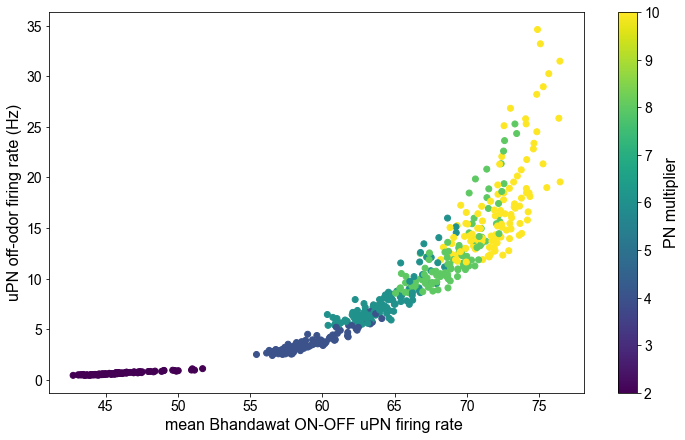

In [56]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'mean_upn_bhand', x_lab = 'mean Bhandawat ON-OFF uPN firing rate ',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [57]:
sub_df = df_res[
       (df_res['p'] == 4) & 
       (df_res[x_var] > 60) &
       (df_res[y_var] < 10) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean')[df_res_cols1].sort_values('max_pca_upn_dists')

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.4_i0.45_p4.0,563.954670,116.339301,288.107362,99.946816,39.650626,65.258542,60.822531,91.261101,302.50,3.912821,...,225.344186,112.728649,476.491828,64.0,16.0,0.0,-68.0,0.380952,4.899549e-08,0.380952
a0.1_e0.45_i0.3_p4.0,566.461450,117.920324,285.383310,97.802002,43.017388,66.017957,62.333333,90.365579,288.00,5.041026,...,222.749638,113.014464,476.763644,60.0,24.0,0.0,-69.5,0.334656,2.815533e-06,0.334656
a0.1_e0.4_i0.4_p4.0,566.428712,115.459782,287.038791,98.120134,40.466467,65.538212,60.522377,90.692153,296.00,4.205128,...,222.973606,111.658861,478.560876,52.0,24.0,0.0,-72.0,0.371693,1.153222e-07,0.371693
a0.1_e0.5_i0.3_p4.0,568.655252,118.771030,287.669949,98.321139,43.231309,66.185090,62.490741,90.913906,292.50,5.181197,...,226.227176,112.067239,479.039795,60.0,28.0,0.0,-68.0,0.322751,7.283579e-06,0.322751
a0.1_e0.5_i0.45_p4.0,565.257295,115.285304,289.404535,99.016690,40.244712,65.414232,60.882716,91.205643,304.00,3.991453,...,224.168864,112.253646,483.037003,52.0,20.0,0.0,-68.0,0.380952,4.899549e-08,0.380952
a0.1_e0.3_i0.2_p4.0,566.225195,117.633535,286.758283,97.868763,44.782580,66.324000,63.459105,90.891225,289.00,5.692308,...,224.940710,111.359087,483.852508,80.0,24.0,0.0,-76.0,0.305556,2.694667e-05,0.305556
a0.1_e0.25_i0.2_p4.0,564.584218,118.725497,285.200934,96.499578,44.240418,66.089001,63.312500,90.158445,293.00,5.517949,...,221.808726,111.246110,483.867013,68.0,36.0,0.0,-72.0,0.306878,2.443268e-05,0.306878
a0.1_e0.45_i0.45_p4.0,563.445111,116.235519,288.446435,100.147018,40.140355,65.155296,60.872685,90.832950,296.00,3.935043,...,224.377109,115.127215,488.152311,64.0,24.0,0.0,-72.0,0.384921,3.370900e-08,0.384921
a0.1_e0.1_i0.2_p4.0,567.928504,119.383045,287.888886,99.339469,42.067633,65.871090,60.962191,90.973264,301.00,5.193162,...,225.983349,113.230954,488.832101,64.0,32.0,0.0,-72.0,0.341270,1.634190e-06,0.341270
a0.1_e0.25_i0.3_p4.0,568.295109,117.477255,288.668828,97.561770,41.457589,65.775306,61.037809,91.054331,296.00,4.591453,...,227.099240,111.441361,490.571992,60.0,28.0,0.0,-72.0,0.343915,1.310404e-06,0.343915


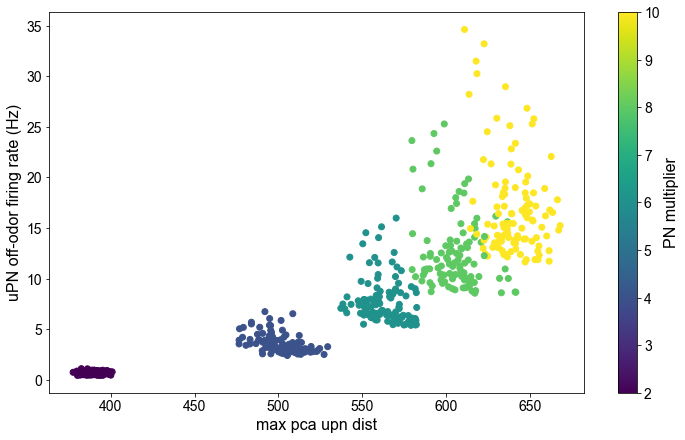

In [58]:
x_var, y_var, c_var = plot_sweep_res(
    x_var = 'max_pca_upn_dists', x_lab = 'max pca upn dist',
    y_var = 'upn_off_mean', y_lab = 'uPN off-odor firing rate (Hz)',
    c_var = 'p', c_lab='PN multiplier',
    highlight_locs=[]
)



In [59]:
sub_df = df_res[
       (df_res['p'] == 4) & 
       (df_res[x_var] > 60) &
       (df_res[y_var] < 10) &
       #(df_res['upn_off_mean'] < 20) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('upn_off_mean').iloc[:5][df_res_cols1]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.2_i1.0_p4.0,552.858937,108.953102,288.131537,105.039712,34.280120,63.028954,56.530864,91.064336,307.0,2.403419,...,224.981062,120.811747,505.280632,44.0,24.0,0.0,-52.0,0.464286,7.569056e-12,0.464286
a0.1_e0.1_i1.0_p4.0,549.676123,109.416865,286.455778,107.769282,34.296977,62.765736,55.432870,90.734129,308.5,2.504274,...,226.867257,121.894743,527.210512,60.0,12.0,0.0,-48.0,0.473545,2.523870e-12,0.473545
a0.1_e0.15_i1.0_p4.0,551.731958,110.612668,290.933556,106.356586,34.259300,62.982318,57.247685,91.942012,313.5,2.519658,...,226.740417,122.718263,513.323961,48.0,12.0,0.0,-52.0,0.462963,8.836154e-12,0.462963
a0.1_e0.3_i1.0_p4.0,549.411470,110.946988,287.289997,105.014482,34.731155,62.899742,57.210648,90.762945,305.5,2.535043,...,223.634167,119.441554,505.003585,44.0,20.0,0.0,-48.0,0.462963,8.836154e-12,0.462963
a0.1_e0.45_i1.0_p4.0,555.166969,110.801657,289.322324,105.410497,34.936610,63.339675,57.827932,91.418419,309.5,2.543590,...,225.090861,119.452677,511.507046,36.0,16.0,0.0,-52.0,0.445767,6.311673e-11,0.445767


In [60]:
sub_df = df_res[
       (df_res['p'] == 6) & 
       #(df_res[x_var] > 60) &
       #(df_res[y_var] < 10) &
        (df_res['upn_off_mean'] < 10) &
        (df_res['mean_upn_bhand'] > 60) &
       #(df_res['eln_on_mean'] < 40) &
       #(df_res['eln_off_mean'] < 20) &
       (1) ]
sub_df.sort_values('mean_pca_upn_dists')#.iloc[:5][df_res_cols1]

,mean_upn_onoff_dists,std_upn_onoff_dists,mean_upn_bhand_dists,std_upn_bhand_dists,mean_upn_onoff,std_upn_onoff,mean_upn_bhand,std_upn_bhand,max_upn_bhand,upn_off_mean,...,mean_pca_upn_dists,std_pca_upn_dists,max_pca_upn_dists,DM1_PN_pre_odor_fr,VA2_PN_pre_odor_fr,VM2_PN_dur_odor_fr,min_PN_dur,kstest_stat,kstest_pval,kstest_2samp_stat
a0.1_e0.45_i0.4_p6.0,676.514075,138.008563,326.353766,103.888703,51.604798,78.402726,67.898148,102.251237,320.5,9.509402,...,251.486339,122.233677,553.421490,84.0,28.0,0.0,-84.0,0.379630,5.544730e-08,0.379630
a0.1_e0.45_i0.45_p6.0,672.243476,137.054119,326.295462,106.657731,50.500499,77.963141,66.725309,102.289820,319.0,8.748718,...,252.864775,122.506500,560.688921,96.0,36.0,0.0,-92.0,0.388889,2.309270e-08,0.388889
a0.1_e0.45_i0.8_p6.0,671.220781,131.961677,330.878985,110.468858,45.282457,77.040621,63.478395,103.520776,324.5,6.441026,...,253.743262,128.090018,553.764072,60.0,24.0,0.0,-80.0,0.453704,2.574641e-11,0.453704
a0.1_e0.25_i0.7_p6.0,672.015957,131.928933,330.912548,110.991422,45.598425,77.139325,62.357253,103.615535,320.5,6.487179,...,254.934588,128.738157,553.083243,68.0,36.0,0.0,-73.5,0.436508,1.755879e-10,0.436508
a0.1_e0.5_i0.45_p6.0,677.427826,138.484951,329.109667,105.659870,50.844499,78.333413,66.686728,102.575736,312.5,8.970940,...,254.954235,122.904828,569.858488,76.0,36.0,0.0,-93.5,0.371693,1.153222e-07,0.371693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0.1_e0.2_i0.8_p6.0,669.468131,131.624866,337.703995,113.112020,44.444408,76.775583,62.799383,105.592011,326.0,6.100855,...,263.324645,131.442311,579.808620,80.0,28.0,0.0,-72.0,0.462963,8.836154e-12,0.462963
a0.1_e0.4_i1.0_p6.0,668.224272,131.026949,336.176934,115.149098,43.745960,76.563100,62.477623,105.392612,326.0,5.547009,...,263.422542,132.329914,579.990662,72.0,32.0,0.0,-72.0,0.472222,2.957301e-12,0.472222
a0.1_e0.3_i1.0_p6.0,667.381337,129.490142,339.749972,116.196038,43.579212,76.328853,62.514660,105.942615,330.0,5.473504,...,264.658927,135.017359,575.798177,64.0,28.0,0.0,-73.5,0.472222,2.957301e-12,0.472222
a0.1_e0.35_i0.9_p6.0,676.377737,130.699705,338.339191,117.176255,44.370915,77.203186,63.385031,106.086123,330.0,5.852991,...,264.878862,135.076980,582.029153,68.0,32.0,0.0,-84.0,0.455026,2.213274e-11,0.455026
